# 1. Installing Python packages

In [1]:
!pip install tensorflow==2.12.0 tensorflowjs==2.0.0 opencv-python mediapipe scikit-learn pandas 

  Using cached prompt_toolkit-1.0.14-py3-none-any.whl (248 kB)
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt_toolkit 3.0.47
    Uninstalling prompt_toolkit-3.0.47:
      Successfully uninstalled prompt_toolkit-3.0.47


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 6.6.3 requires prompt-toolkit>=3.0.30, but you have prompt-toolkit 1.0.14 which is incompatible.
ipython 8.26.0 requires prompt-toolkit<3.1.0,>=3.0.41, but you have prompt-toolkit 1.0.14 which is incompatible.


# 2. Importing libraries

In [2]:
import cv2
import numpy as np
import os
import time
import mediapipe as mp
import tensorflowjs as tfjs
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D,Flatten, LSTM, Dense, Dropout, Input
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, classification_report 

# 3. Creating variables 

In [3]:
DATA_PATH = os.path.join('MP_Data')
signs = np.array([chr(i) for i in range(ord('A'), ord('Z')+1)] + ['next', 'space', 'backspace'])
mp_hands = mp.solutions.hands
modelH = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.4)
drawing_utils = mp.solutions.drawing_utils
drawing_styles = mp.solutions.drawing_styles
data_for_each_sign = 100
data_length = 45
sign_map = {sign: index for index, sign in enumerate(signs)}
labels_array = np.zeros((29*100, 29), dtype=int)
for i in range(29):
    labels_array[i*100:(i+1)*100, i] = 1

# 4. Defining usefull functions

In [4]:
def get_data(results):
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0].landmark
        arr = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks]).flatten()
    else:
        arr = np.zeros(63)
    return arr

In [5]:
def draw_landmarks(results, frame):
    if results.multi_hand_landmarks:
        for landmark in results.multi_hand_landmarks:
            drawing_utils.draw_landmarks(
                frame,  
                landmark,
                mp_hands.HAND_CONNECTIONS, 
                drawing_styles.get_default_hand_landmarks_style(),
                drawing_styles.get_default_hand_connections_style())
    return frame

# 5. Collecting data for training

In [6]:
for sign in signs: 
    for index in range(data_for_each_sign):
        try: 
            os.makedirs(os.path.join(DATA_PATH, sign, str(index)))
        except:
            pass

In [7]:
cap = cv2.VideoCapture(0)
for sign in signs:
    for index in range(data_for_each_sign):
        for data_index in range(data_length):
            ret, frame = cap.read()
            frame_flipped = cv2.flip(frame, 1)
            image = cv2.cvtColor(frame_flipped, cv2.COLOR_BGR2RGB)
            results = modelH.process(image) 

            drawn_frame = draw_landmarks(results, frame_flipped)
           
            if data_index != 0: 
                cv2.imshow('Frame', drawn_frame)
            else:
                cv2.rectangle(drawn_frame, (50,50), (150,150), (0, 0, 255), -1)
                cv2.putText(drawn_frame, sign, (75, 125), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 0), 5)
                cv2.imshow('Frame', drawn_frame)
                cv2.waitKey(1000)
                
            np.save(os.path.join(DATA_PATH, sign, str(index), str(data_index)), get_data(results))
            
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
                    
cap.release()
cv2.destroyAllWindows()

In [8]:
all_data = []
for sign in signs:
    for index in range(data_for_each_sign):
        video = []
        for data_index in range(data_length):
            loaded_data = np.load(os.path.join(DATA_PATH, sign, str(index), "{}.npy".format(data_index)))
            video.append(loaded_data)
        all_data.append(video)

In [9]:
X = np.array(all_data)
Y = labels_array
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

# 6. Creating and Training Model

In [10]:
model = Sequential()

# Input layer
input_layer = Input(shape=(45, 63), name='input_layer')
model.add(input_layer)

# Convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layers
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(64))
model.add(Dropout(0.5))

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(29, activation='softmax')) # Assuming 29 classes

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [13]:
model.fit(X_train, Y_train, epochs=75,  callbacks=[tb_callback])

Epoch 1/75
73/73 [==============================] - 4s 13ms/step - loss: 3.3619 - accuracy: 0.0444
Epoch 2/75
73/73 [==============================] - 1s 12ms/step - loss: 3.0611 - accuracy: 0.1047
Epoch 3/75
73/73 [==============================] - 1s 12ms/step - loss: 2.4298 - accuracy: 0.2147
Epoch 4/75
73/73 [==============================] - 1s 13ms/step - loss: 1.9309 - accuracy: 0.3147
Epoch 5/75
73/73 [==============================] - 1s 12ms/step - loss: 1.5841 - accuracy: 0.4129
Epoch 6/75
73/73 [==============================] - 1s 13ms/step - loss: 1.3618 - accuracy: 0.4953
Epoch 7/75
73/73 [==============================] - 1s 13ms/step - loss: 1.0563 - accuracy: 0.5763
Epoch 8/75
73/73 [==============================] - 1s 12ms/step - loss: 1.0132 - accuracy: 0.5966
Epoch 9/75
73/73 [==============================] - 1s 13ms/step - loss: 0.9270 - accuracy: 0.6414
Epoch 10/75
73/73 [==============================] - 1s 13ms/step - loss: 0.8950 - accuracy: 0.6435
Epoch 11/

# 7. Saving model in H5 and TFJS format

In [14]:
model.save('model.h5')

In [15]:
model = tf.keras.models.load_model('model.h5')
tfjs.converters.save_keras_model(model, 'tfjs_model')

# 8. Visualizing and evaluating the model

In [19]:
metrics = model.evaluate(X_test, Y_test, verbose=1)

19/19 [==============================] - 1s 5ms/step - loss: 0.1385 - accuracy: 0.9552


In [20]:
yhat = model.predict(X_test)

19/19 [==============================] - 1s 5ms/step


In [21]:
ytrue = np.argmax(Y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

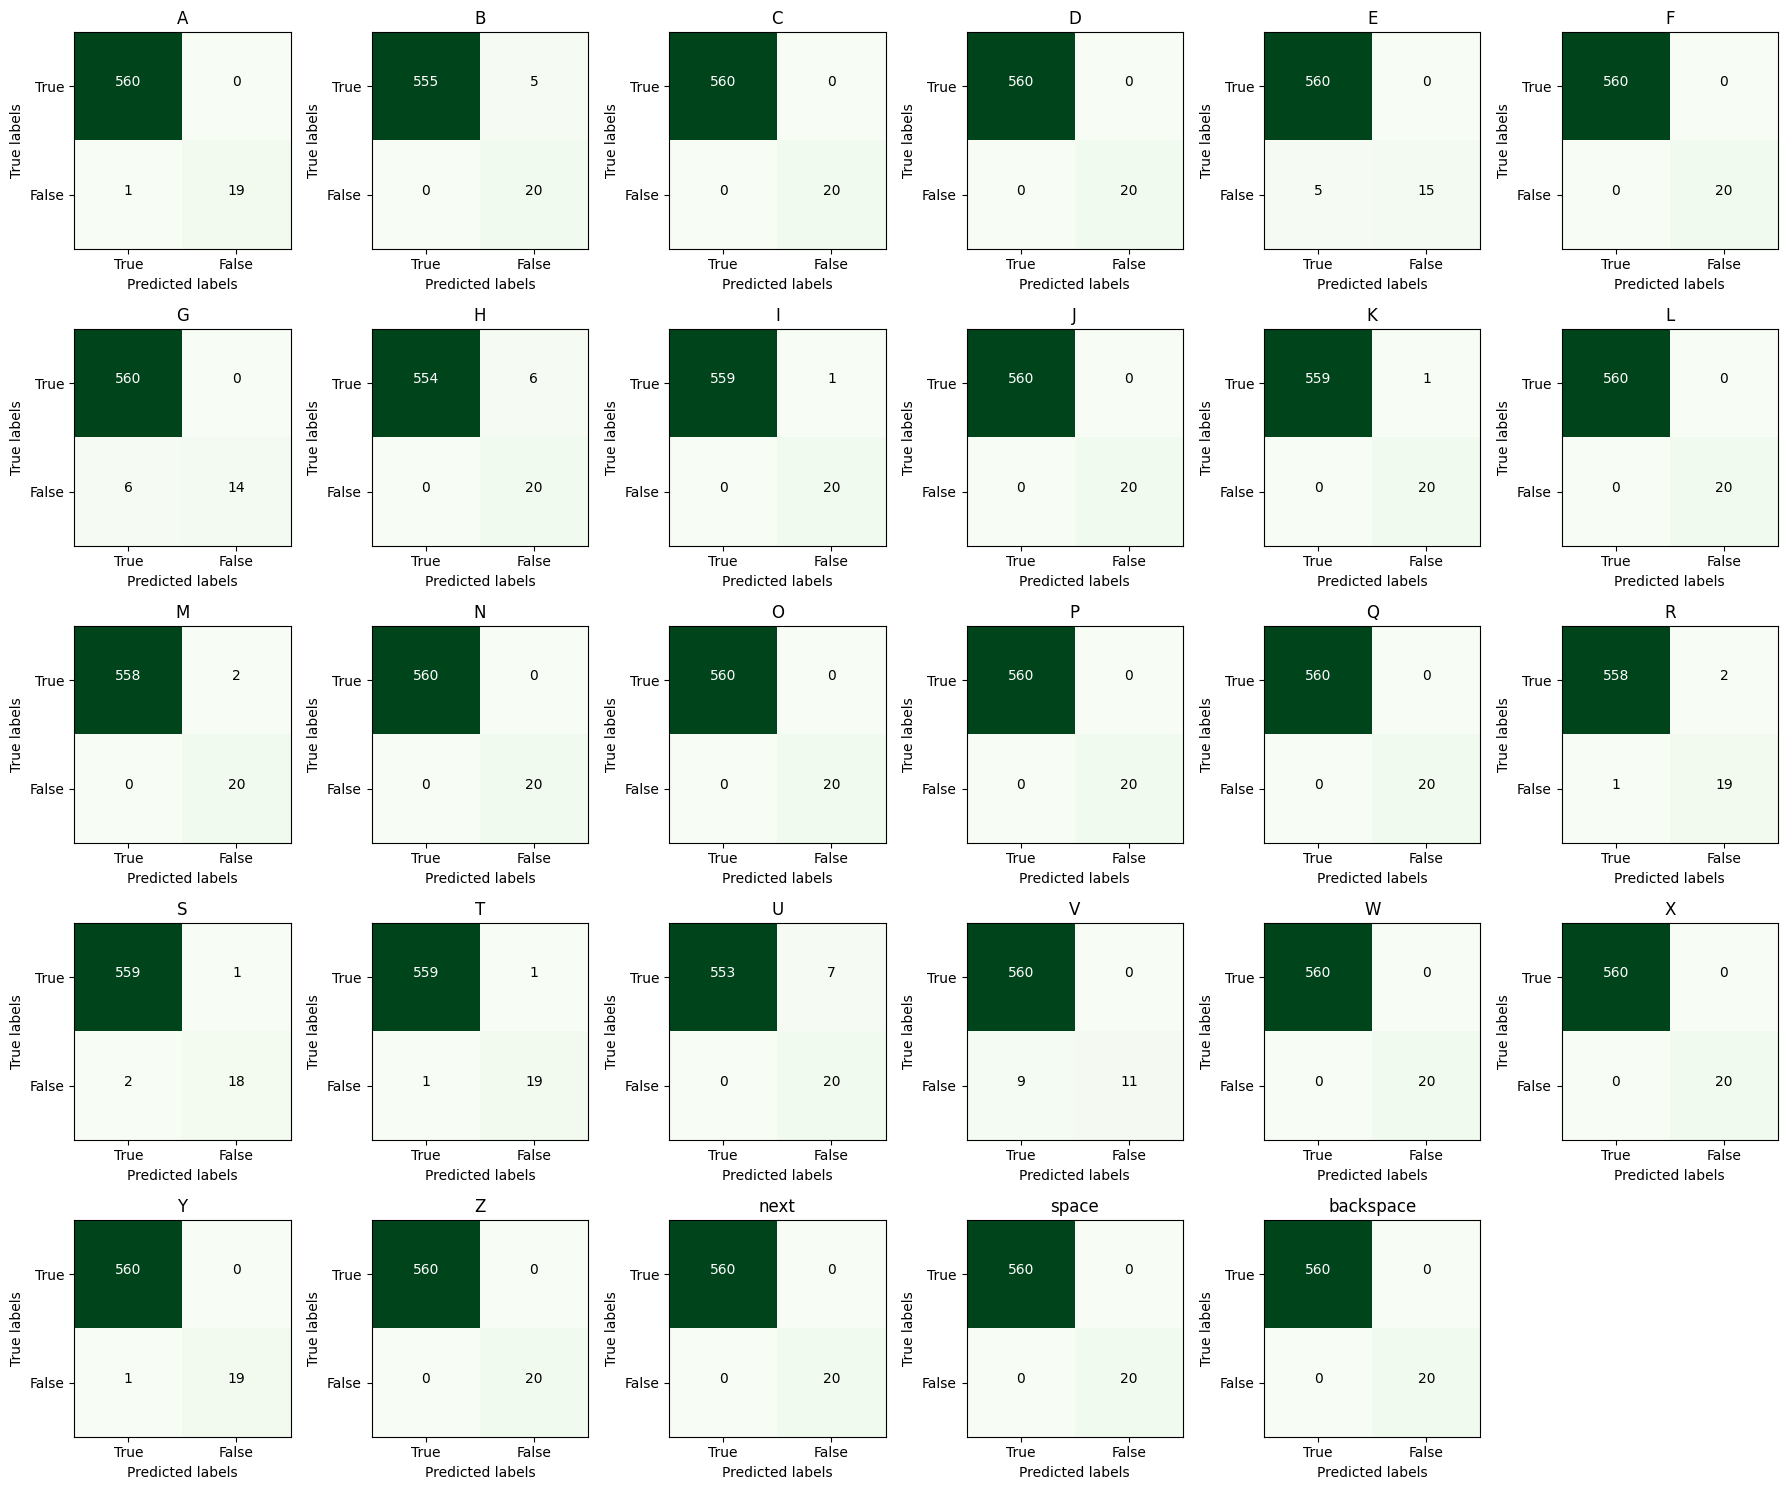

In [22]:
cms = multilabel_confusion_matrix(ytrue, yhat)
class_names = ['Class_1', 'Class_2', 'Class_3', ..., 'Class_29']  # replace with your actual class names
num_classes = len(cms)
fig, axs = plt.subplots(5, 6, figsize=(18, 15)) 
for i, ax in enumerate(axs.flatten()):
    if i < num_classes:
        cm = cms[i]
        ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
        ax.set_title(signs[i])
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.grid(False)

        tick_marks = np.arange(len(cm))
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(['True', 'False'])
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(['True', 'False'])

        thresh = cm.max() / 2.
        for j, k in np.ndindex(cm.shape):
            ax.text(k, j, format(cm[j, k], 'd'), horizontalalignment="center", color="white" if cm[j, k] > thresh else "black")
    else:
        fig.delaxes(ax)  
plt.tight_layout()
plt.show()

19/19 [==============================] - 0s 5ms/step


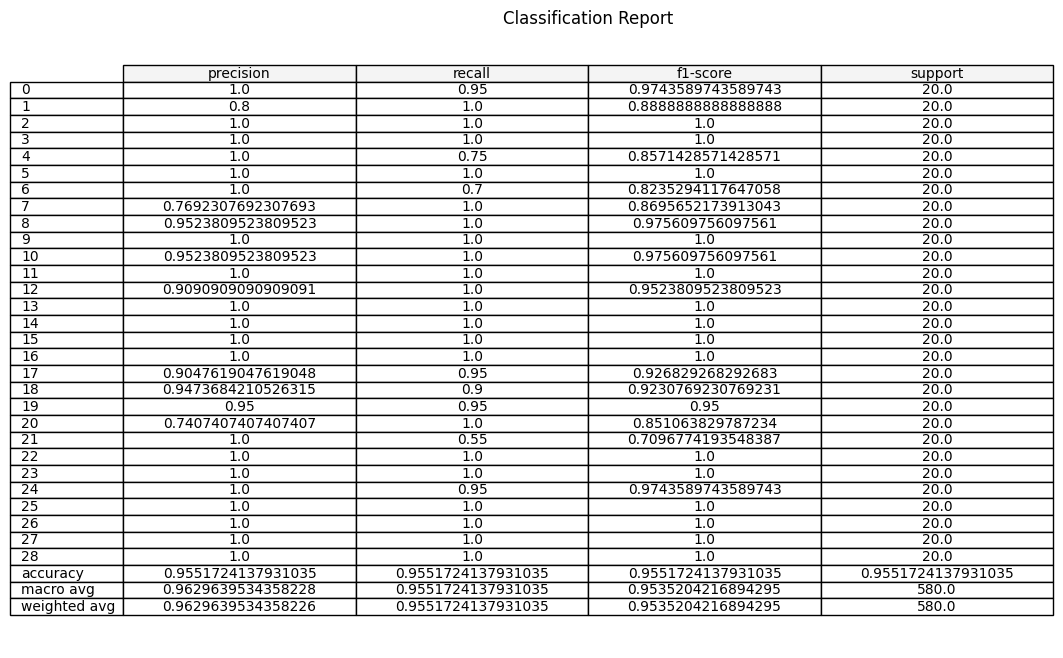

In [24]:
import pandas as pd
y_test_categorical = to_categorical(Y_test, num_classes=29)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)
report = classification_report(y_true, y_pred_classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=report_df.values,
                 colLabels=report_df.columns,
                 rowLabels=report_df.index,
                 cellLoc='center',
                 loc='center',
                 colColours=['#f4f4f4']*report_df.shape[1])
plt.title('Classification Report')
plt.show()